### 贝叶斯优化实例

选择保险数据集，来进行分类任务预测，基于贝叶斯和随机优化方法进行对比分析

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold

MAX_EVALS = 500
N_FOLDS = 10

In [2]:
# Read in data and separate into training and testing sets
data = pd.read_csv('data/caravan-insurance-challenge.csv')
data.head()

ORIGIN  MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  \
0  train       33         1        3         2         8       0       5   
1  train       37         1        2         2         8       1       4   
2  train       37         1        2         2         8       0       4   
3  train        9         1        3         3         3       2       3   
4  train       40         1        4         2        10       1       4   

   MGODOV  MGODGE   ...     APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  \
0       1       3   ...            0        0        0       1        0   
1       1       4   ...            0        0        0       1        0   
2       2       4   ...            0        0        0       1        0   
3       2       4   ...            0        0        0       1        0   
4       1       4   ...            0        0        0       1        0   

   APLEZIER  AFIETS  AINBOED  ABYSTAND  CARAVAN  
0         0       0        0         0        0  
1         0       0        0         0        0  
2         0       0        0         0        0  
3         0       0        0         0        0  
4         0       0        0         0        0  

[5 rows x 87 columns]

In [3]:
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

In [4]:
# Extract the labels and format properly
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

In [5]:
# Drop the unneeded columns
train = train.drop(['ORIGIN', 'CARAVAN'],axis=1)
test = test.drop(['ORIGIN', 'CARAVAN'],axis=1)

# Convert to numpy array for splitting in cross validation
features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)
train.head()

Train shape:  (5822, 85)
Test shape:  (4000, 85)


MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  MGODOV  \
0       33         1        3         2         8       0       5       1   
1       37         1        2         2         8       1       4       1   
2       37         1        2         2         8       0       4       2   
3        9         1        3         3         3       2       3       2   
4       40         1        4         2        10       1       4       1   

   MGODGE  MRELGE    ...     ALEVEN  APERSONG  AGEZONG  AWAOREG  ABRAND  \
0       3       7    ...          0         0        0        0       1   
1       4       6    ...          0         0        0        0       1   
2       4       3    ...          0         0        0        0       1   
3       4       5    ...          0         0        0        0       1   
4       4       7    ...          0         0        0        0       1   

   AZEILPL  APLEZIER  AFIETS  AINBOED  ABYSTAND  
0        0         0       0        0         0  
1        0         0       0        0         0  
2        0         0       0        0         0  
3        0         0       0        0         0  
4        0         0       0        0         0  

[5 rows x 85 columns]

### 标签的分布

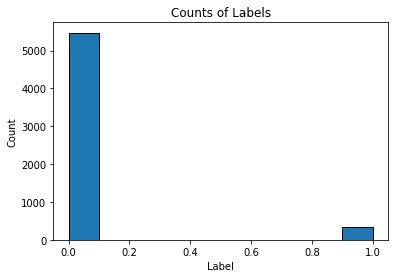

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(labels, edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

样本是不平衡数据，所以在这里选择使用ROC曲线来进行评估，接下来我们的目标就是使得其AUC的值越大越好。

### GBDT模型

使用LightGBM包来进行建模

In [7]:
# Model with default hyperparameters
model = lgb.LGBMClassifier()
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

先来看一下默认参数的效果，这个就是基础模型了，我们要做的就是尽可能高的来提升AUC指标。

In [8]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))


The baseline score on the test set is 0.7092.
The baseline training time is 0.1886 seconds


只有6000条数据，速度还是很快的。

## Random Search 

skleran包的 RandomizedSearchCV 可以完成这个任务，但是没有Early Stopping功能所以我们来自己写一下。

In [9]:
import random

### 参数空间

In [10]:
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

这些就是默认参数了

设置参数取值范围，其中有些参数设置成了对数分布，比如学习率，因为这类参数都是要累乘才能发挥效果的，一般经验都是写成log分布形式。还有一些参数得在其他参数控制下来进行选择，这些设置起来还得麻烦一点。

In [11]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))


来看一下学习率的分布

[对数分布的解释可以看一下这个](https://www.quora.com/Why-does-one-sample-the-log-space-when-searching-for-good-Hyper-Parameters-for-Machine-Learning) 

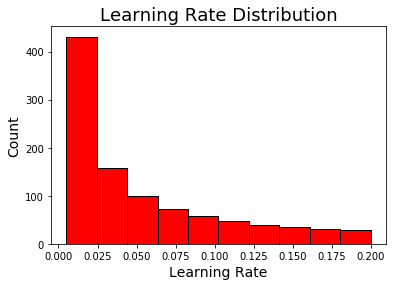

In [12]:
plt.hist(param_grid['learning_rate'], color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

再来看一下叶子数目的分布，均匀分布

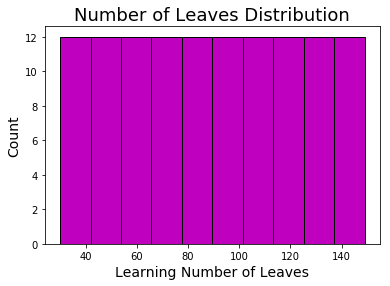

In [13]:
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

### 在参数空间采样试试看

In [34]:
params = {key: random.sample(value, 2) for key, value in param_grid.items()}
params

{'boosting_type': ['gbdt', 'dart'],
 'class_weight': ['balanced', None],
 'colsample_bytree': [0.6, 0.9555555555555555],
 'learning_rate': [0.02473753188230597, 0.008322917480173492],
 'min_child_samples': [390, 100],
 'num_leaves': [73, 56],
 'reg_alpha': [0.6122448979591836, 0.673469387755102],
 'reg_lambda': [0.6326530612244897, 0.5306122448979591],
 'subsample_for_bin': [260000, 240000]}

In [28]:
# Randomly sample parameters for gbm
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'boosting_type': 'goss',
 'class_weight': None,
 'colsample_bytree': 0.6,
 'learning_rate': 0.010084772343724504,
 'min_child_samples': 195,
 'num_leaves': 100,
 'reg_alpha': 0.6530612244897959,
 'reg_lambda': 0.7755102040816326,
 'subsample_for_bin': 40000}

有些个参数还是受限制的

In [22]:
params['subsample'] = random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
params

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 0.68888888888888888,
 'learning_rate': 0.12652481251621955,
 'min_child_samples': 180,
 'num_leaves': 109,
 'reg_alpha': 0.4081632653061224,
 'reg_lambda': 0.081632653061224483,
 'subsample': 0.92929292929292928,
 'subsample_for_bin': 200000}

### 交叉验证LightGBM

In [23]:
# Create a lgb dataset
train_set = lgb.Dataset(features, label = labels)

early_stopping_rounds = 100：如果再连续构造100次还是没进步，那就拉倒了。

In [24]:
# Perform cross validation with 10 folds
r = lgb.cv(params, train_set, num_boost_round = 10000, nfold = 10, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 50)

# Highest score
r_best = np.max(r['auc-mean'])

# Standard deviation of best score
r_best_std = r['auc-stdv'][np.argmax(r['auc-mean'])]

print('The maximium ROC AUC on the validation set was {:.5f} with std of {:.5f}.'.format(r_best, r_best_std))
print('The ideal number of iterations was {}.'.format(np.argmax(r['auc-mean']) + 1))

The maximium ROC AUC on the validation set was 0.76262 with std of 0.03361.
The ideal number of iterations was 16.


### Results Dataframe

结果放到这里，过后再对比

In [25]:
# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

### Objective Function

用AUC指标当做我们的目标

In [26]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    end = timer()
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Return list of results
    return [loss, params, iteration, n_estimators, end - start]

### 来执行随机调参

这里会慢一些，因为迭代次数很多，稍等一会。

In [27]:
%%capture

random.seed(50)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    print(params)
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

In [28]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

loss                                             params iteration  \
0   0.22943  {'class_weight': 'balanced', 'boosting_type': ...        36   
1  0.230816  {'class_weight': 'balanced', 'boosting_type': ...       284   
2   0.23087  {'class_weight': 'balanced', 'boosting_type': ...       402   
3  0.231032  {'class_weight': 'balanced', 'boosting_type': ...        54   
4  0.231288  {'class_weight': None, 'boosting_type': 'gbdt'...       419   

  estimators      time  
0        197   3.05169  
1        122   2.28513  
2        147   1.25936  
3         16  0.601705  
4        246   1.77756

### Random Search结果

来看一下效果咋样吧！

In [29]:
random_results.loc[0, 'params']

{'boosting_type': 'dart',
 'class_weight': 'balanced',
 'colsample_bytree': 0.59999999999999998,
 'learning_rate': 0.055329283179111968,
 'metric': 'auc',
 'min_child_samples': 280,
 'num_leaves': 143,
 'reg_alpha': 0.61224489795918358,
 'reg_lambda': 0.69387755102040816,
 'subsample': 0.77272727272727271,
 'subsample_for_bin': 140000,
 'verbose': 1}

In [30]:
# Find the best parameters and number of estimators
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators, n_jobs = -1, 
                                       objective = 'binary', **best_random_params, random_state = 50)

# Fit on the training data
best_random_model.fit(features, labels)

# Make test predictions
predictions = best_random_model.predict_proba(test_features)[:, 1]


print('The best model from random search scores {:.4f} on the test data.'.format(roc_auc_score(test_labels, predictions)))
print('This was achieved using {} search iterations.'.format(random_results.loc[0, 'iteration']))

The best model from random search scores 0.7262 on the test data.
This was achieved using 36 search iterations.


### 贝叶斯优化

还是这几步走:

1. Objective function
2. Domain space
3. Hyperparameter optimization algorithm
4. History of results

### Objective Function 



In [31]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

## Domain Space

In [32]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [33]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

来看一下长啥样

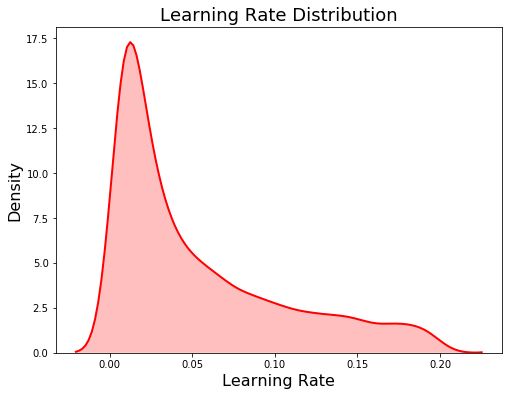

In [34]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); 
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

 `quniform`的效果

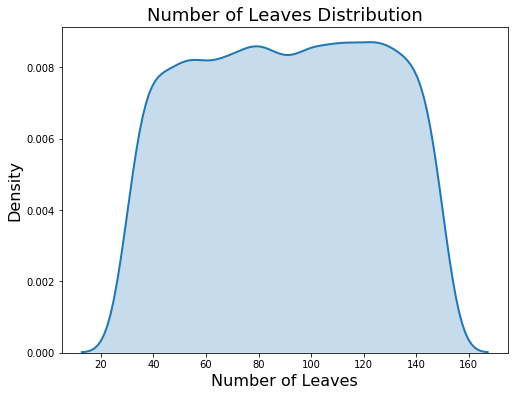

In [35]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

In [36]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
params = sample(boosting_type)
params

{'boosting_type': {'boosting_type': 'goss', 'subsample': 1.0}}

可以设置默认值

In [37]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = params['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
params['boosting_type'] = params['boosting_type']['boosting_type']
params['subsample'] = subsample

params

{'boosting_type': 'goss', 'subsample': 1.0}

### 参数分布汇总

关于各种参数分布的解释可以参考这个： [Hyperopt文档](https://github.com/hyperopt/hyperopt/wiki/FMin)

In [38]:
# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

### 参数采样结果看一下

In [39]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 0.8913572680518538,
 'learning_rate': 0.19514985930702622,
 'min_child_samples': 430.0,
 'num_leaves': 137.0,
 'reg_alpha': 0.20472815470217032,
 'reg_lambda': 0.728865633788817,
 'subsample': 0.6966685987470351,
 'subsample_for_bin': 240000.0}

In [40]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'goss',
 'class_weight': None,
 'colsample_bytree': 0.996457129696336,
 'learning_rate': 0.03808232928032949,
 'min_child_samples': 310.0,
 'num_leaves': 148.0,
 'reg_alpha': 0.22326882092185973,
 'reg_lambda': 0.9294515859734608,
 'subsample': 1.0,
 'subsample_for_bin': 260000.0}

### 准备贝叶斯优化

In [41]:
from hyperopt import tpe

# optimization algorithm
tpe_algorithm = tpe.suggest

In [42]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

可以将结果保存下来

In [43]:
# File to save first results
out_file = 'results/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

### 来两把吃鸡，回来看结果

In [44]:
from hyperopt import fmin

In [45]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

看看结果吧

In [46]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'estimators': 40,
  'iteration': 343,
  'loss': 0.22673915905384556,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.7055921914976446,
   'learning_rate': 0.0797752399364121,
   'metric': 'auc',
   'min_child_samples': 275,
   'num_leaves': 132,
   'reg_alpha': 0.26766855252147537,
   'reg_lambda': 0.6831957130168865,
   'subsample': 0.5000022752007336,
   'subsample_for_bin': 260000,
   'verbose': 1},
  'status': 'ok',
  'train_time': 0.6772433706737502},
 {'estimators': 25,
  'iteration': 454,
  'loss': 0.22783833568389134,
  'params': {'boosting_type': 'dart',
   'class_weight': None,
   'colsample_bytree': 0.6955474549028398,
   'learning_rate': 0.153434909751081,
   'metric': 'auc',
   'min_child_samples': 255,
   'num_leaves': 83,
   'reg_alpha': 0.21141602829063957,
   'reg_lambda': 0.3913899467719878,
   'subsample': 0.6476145165648913,
   'subsample_for_bin': 160000,
   'verbose': 1},
  'status': 'ok',
  'train_time': 0.960713463451611

保存下来以后观察

In [47]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

loss                                             params  iteration  \
0  0.226739  {'boosting_type': 'gbdt', 'class_weight': None...        343   
1  0.227838  {'boosting_type': 'dart', 'class_weight': None...        454   
2  0.227960  {'boosting_type': 'gbdt', 'class_weight': None...        417   
3  0.228056  {'boosting_type': 'gbdt', 'class_weight': 'bal...        215   
4  0.228880  {'boosting_type': 'dart', 'class_weight': None...        302   

   estimators  train_time  
0          40    0.677243  
1          25    0.960713  
2          21    0.575145  
3          18    0.620720  
4          86    1.575161

把字符串转换成字典，得这么转换下，也可以用其他方式，只是为了转换下格式而已。

In [48]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7055921914976446,
 'learning_rate': 0.0797752399364121,
 'metric': 'auc',
 'min_child_samples': 275,
 'num_leaves': 132,
 'reg_alpha': 0.26766855252147537,
 'reg_lambda': 0.6831957130168865,
 'subsample': 0.5000022752007336,
 'subsample_for_bin': 260000,
 'verbose': 1}

### 看看在测试集上的效果

In [49]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7055921914976446,
        learning_rate=0.0797752399364121, max_depth=-1, metric='auc',
        min_child_samples=275, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=40, n_jobs=-1, num_leaves=132, objective='binary',
        random_state=50, reg_alpha=0.26766855252147537,
        reg_lambda=0.6831957130168865, silent=True,
        subsample=0.5000022752007336, subsample_for_bin=260000,
        subsample_freq=0, verbose=1)

In [50]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.73027 AUC ROC on the test set.
This was achieved after 343 search iterations


效果要比随机的略好一点

### 来比比吧

In [55]:
best_random_params['method'] = 'random search'
best_bayes_params['method'] = 'Bayesian optimization'
best_params = pd.DataFrame(best_bayes_params, index = [0]).append(pd.DataFrame(best_random_params, index = [0]), 
                                                                  ignore_index = True)
best_params

boosting_type class_weight  colsample_bytree  learning_rate  \
0          gbdt         None          0.705592       0.079775   
1          dart     balanced          0.600000       0.055329   

                  method metric  min_child_samples  num_leaves  reg_alpha  \
0  Bayesian optimization    auc                275         132   0.267669   
1          random search    auc                280         143   0.612245   

   reg_lambda  subsample  subsample_for_bin  verbose  
0    0.683196   0.500002             260000        1  
1    0.693878   0.772727             140000        1

### 调参过程可视化展示

In [42]:
# Create a new dataframe for storing parameters
random_params = pd.DataFrame(columns = list(random_results.loc[0, 'params'].keys()),
                            index = list(range(len(random_results))))

# Add the results with each parameter a different column
for i, params in enumerate(random_results['params']):
    random_params.loc[i, :] = list(params.values())
    
random_params['loss'] = random_results['loss']
random_params['iteration'] = random_results['iteration']
random_params.head()

class_weight boosting_type num_leaves learning_rate subsample_for_bin  \
0         None          gbdt         41    0.00694538            120000   
1     balanced          gbdt        117     0.0233183            160000   
2         None          gbdt        114     0.0113078            260000   
3         None          gbdt         79     0.0118202             60000   
4     balanced          dart        143     0.0553293            140000   

  min_child_samples reg_alpha reg_lambda colsample_bytree subsample metric  \
0               255  0.591837   0.510204         0.644444   0.80303    auc   
1               250  0.755102   0.591837         0.777778  0.560606    auc   
2               280  0.142857   0.387755         0.688889  0.565657    auc   
3               260  0.571429   0.836735              0.6  0.666667    auc   
4               280  0.612245   0.693878              0.6  0.772727    auc   

  verbose      loss iteration  
0       1  0.231496       146  
1       1  0.231815       402  
2       1  0.231864       419  
3       1  0.231964       369  
4       1  0.231978        36

In [43]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

boosting_type class_weight colsample_bytree learning_rate min_child_samples  \
0          gbdt     balanced         0.712519     0.0225926               250   
1          gbdt         None         0.620649     0.0179345               260   
2          gbdt         None         0.702478     0.0139816               255   
3          gbdt     balanced         0.679909     0.0181395               245   
4          gbdt     balanced         0.687608     0.0274153               255   

  num_leaves reg_alpha reg_lambda subsample_for_bin subsample metric verbose  \
0         49  0.203521   0.645513            200000  0.983566    auc       1   
1         30  0.209298   0.894689             20000  0.873149    auc       1   
2         36  0.235151   0.807442             20000  0.995741    auc       1   
3         43  0.652347   0.572782            180000  0.922594    auc       1   
4         45  0.455783    0.62199             20000  0.790035    auc       1   

       loss  iteration  
0  0.228987        413  
1  0.229259          5  
2  0.229278         66  
3  0.229735        406  
4  0.229737        309

### 学习率

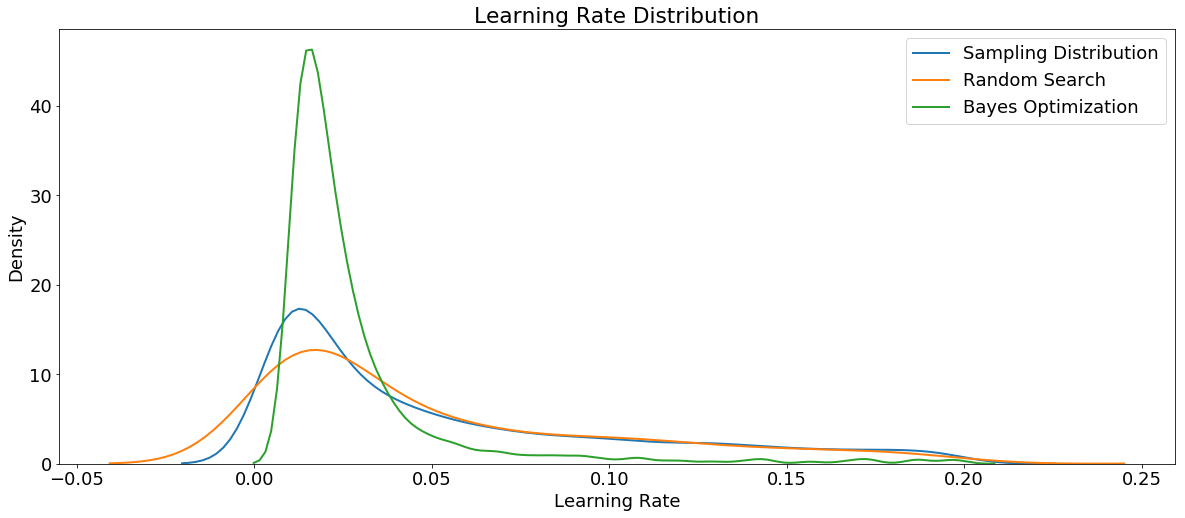

In [44]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 2)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 2)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 2)
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

### Boosting Type 


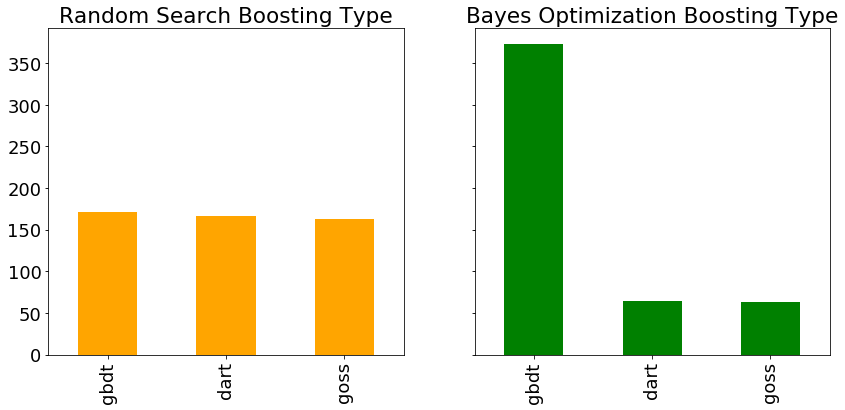

In [45]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

In [46]:
print('Random Search boosting type percentages')
100 * random_params['boosting_type'].value_counts() / len(random_params)

Random Search boosting type percentages


goss    34.2
dart    33.2
gbdt    32.6
Name: boosting_type, dtype: float64

In [47]:
print('Bayes Optimization boosting type percentages')
100 * bayes_params['boosting_type'].value_counts() / len(bayes_params)

Bayes Optimization boosting type percentages


gbdt    74.6
dart    12.8
goss    12.6
Name: boosting_type, dtype: float64

选择的方法还是有些区别的

### 数值型参数

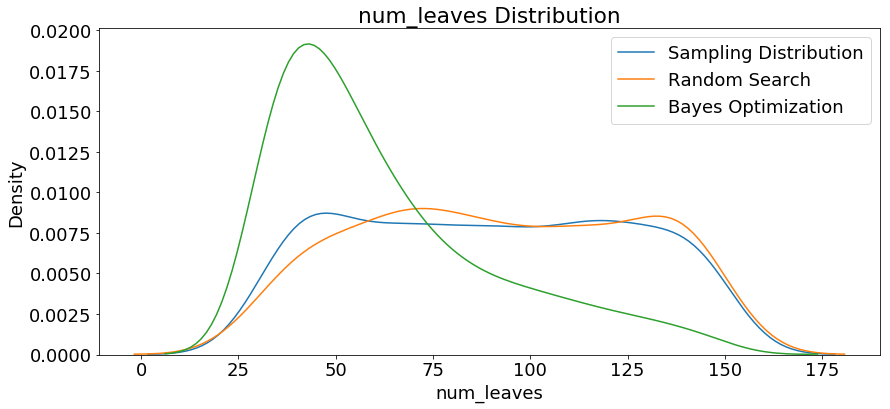

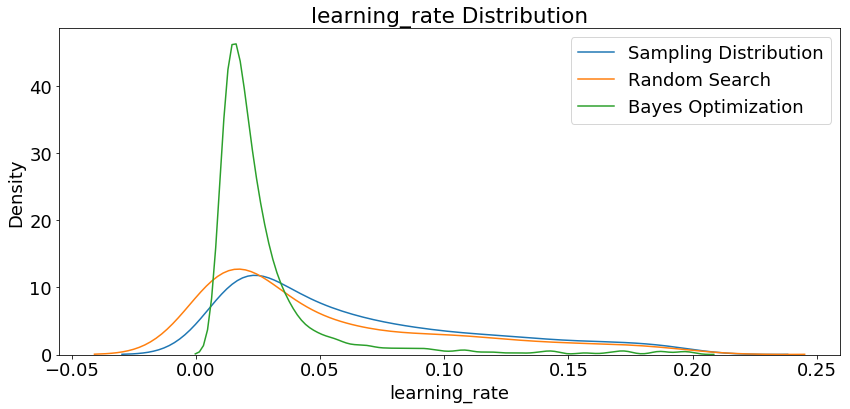

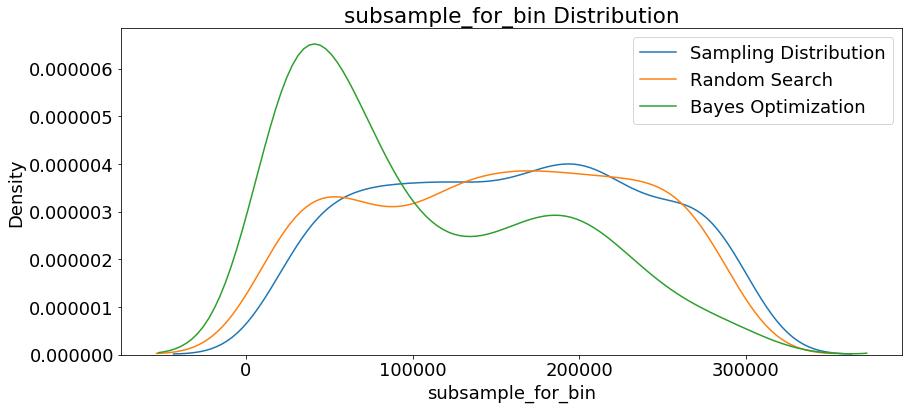

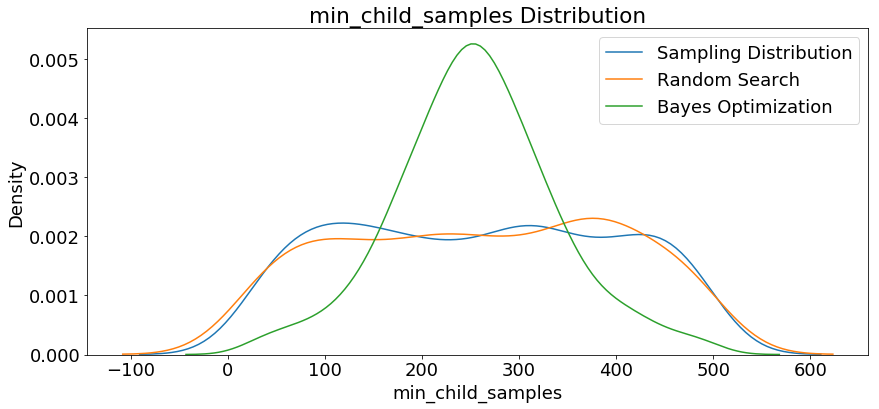

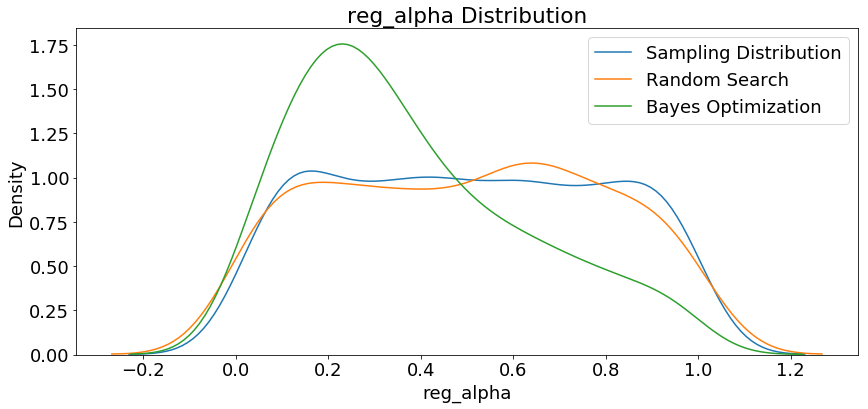

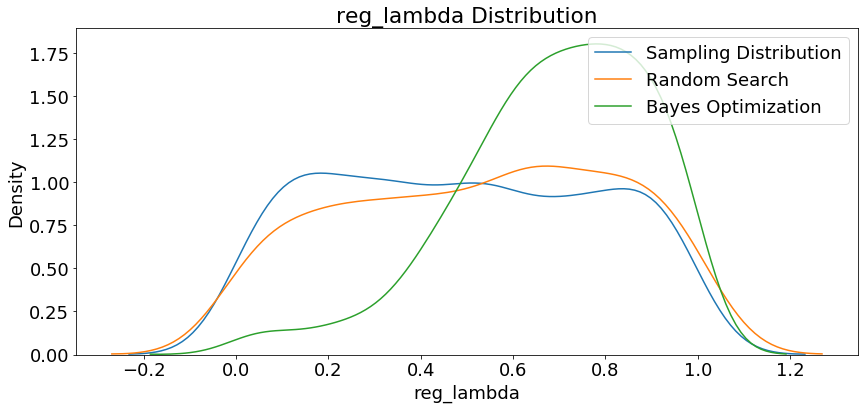

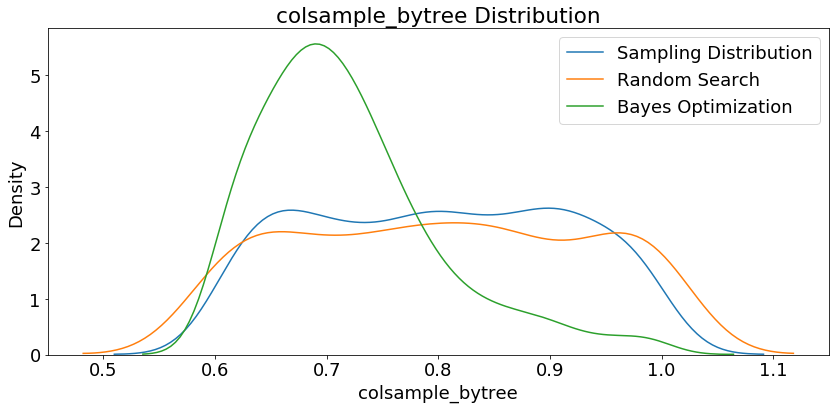

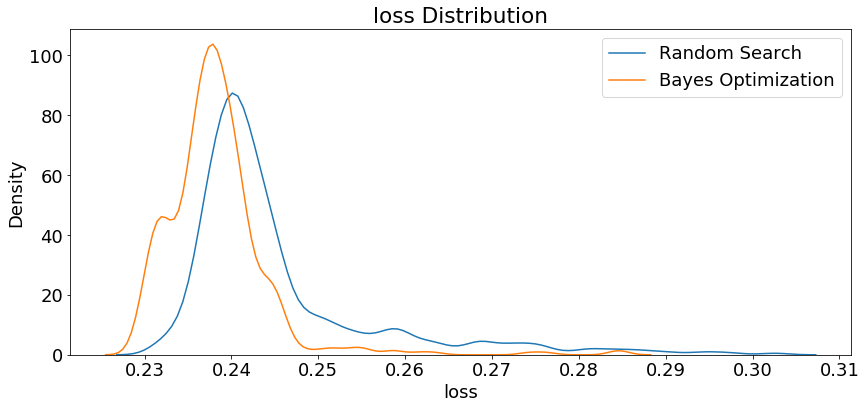

In [48]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'boosting_type', 'iteration', 'subsample', 'metric', 'verbose']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
        sns.kdeplot(random_params[hyper], label = 'Random Search')
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization')
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

总体来说 贝叶斯优化在后期能达到更好的效果，前期可能有点麻烦

### 对比下参数变换情况

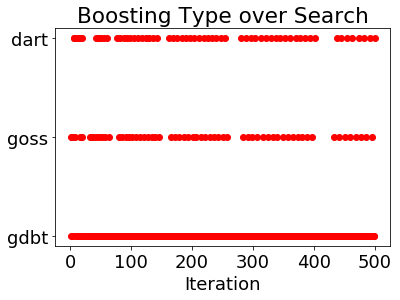

In [49]:
# Map boosting type to integer (essentially label encoding)
bayes_params['boosting_int'] = bayes_params['boosting_type'].replace({'gbdt': 1, 'goss': 2, 'dart': 3})

# Plot the boosting type over the search
plt.plot(bayes_params['iteration'], bayes_params['boosting_int'], 'ro')
plt.yticks([1, 2, 3], ['gdbt', 'goss', 'dart']);
plt.xlabel('Iteration'); plt.title('Boosting Type over Search');

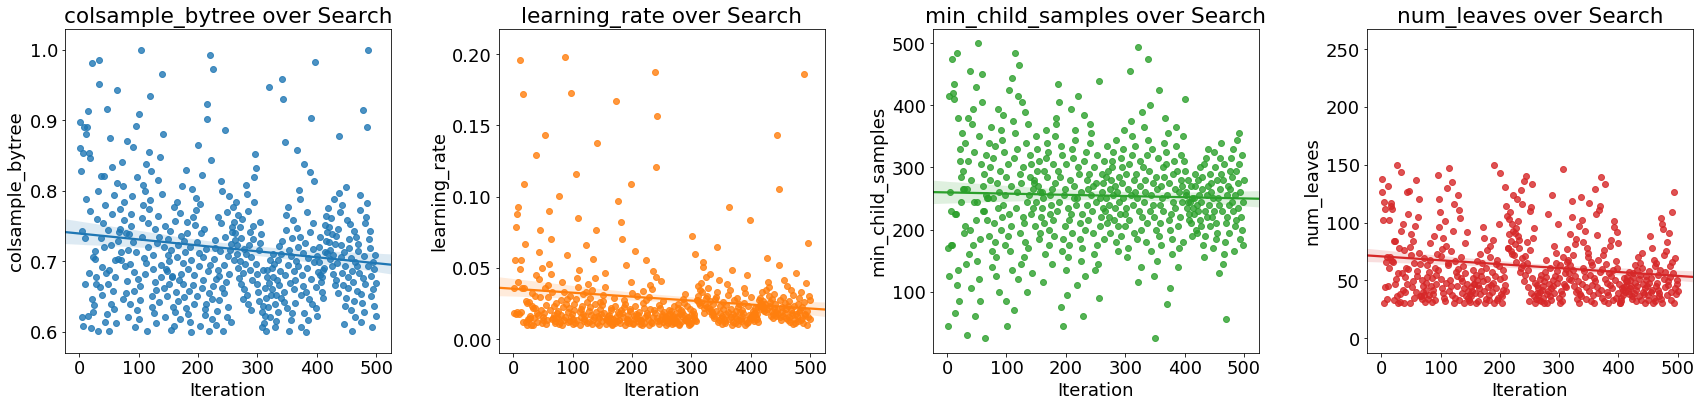

In [50]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

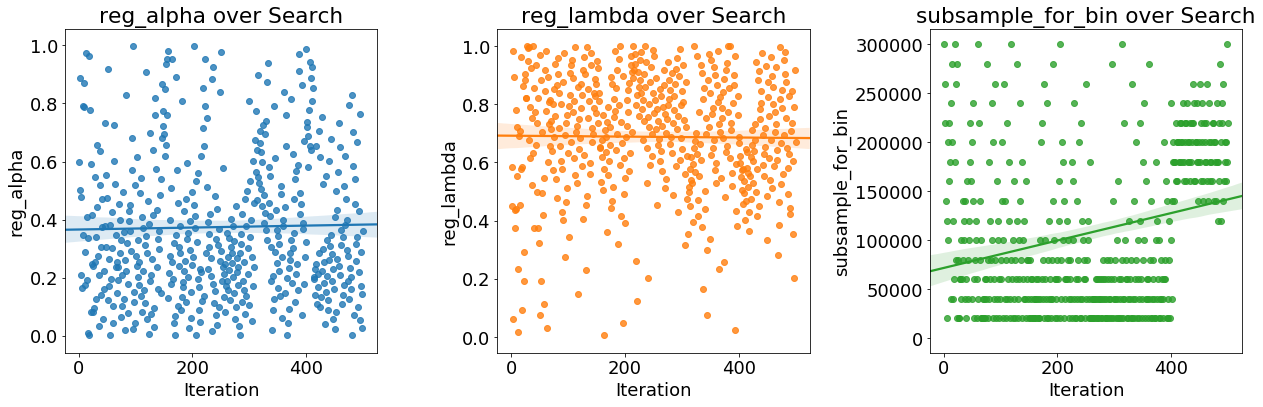

In [51]:
fig, axs = plt.subplots(1, 3, figsize = (18, 6))
i = 0

# Scatterplot of next three hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin']):
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

贝叶斯还是有方向和目标的

### 损失的变化


In [52]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': 1 - random_params['loss'], 'iteration': random_params['iteration'], 'search': 'random'})
scores = scores.append(pd.DataFrame({'ROC AUC': 1 - bayes_params['loss'], 'iteration': bayes_params['iteration'], 'search': 'Bayes'}))

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

ROC AUC  iteration  search
0  0.768504        146  random
1  0.768185        402  random
2  0.768136        419  random
3  0.768036        369  random
4  0.768022         36  random

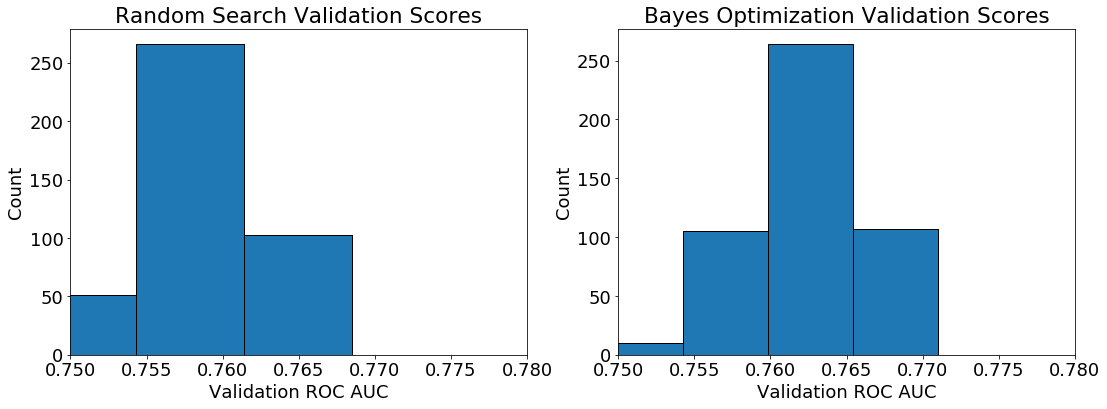

In [53]:
plt.figure(figsize = (18, 6))

# Random search scores
plt.subplot(1, 2, 1)
plt.hist(1 - random_results['loss'].astype(np.float64), label = 'Random Search', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Random Search Validation Scores")
plt.xlim(0.75, 0.78)

# Bayes optimization scores
plt.subplot(1, 2, 2)
plt.hist(1 - bayes_params['loss'], label = 'Bayes Optimization', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Bayes Optimization Validation Scores");
plt.xlim(0.75, 0.78);

贝叶斯优化的是不是好一些的呀!

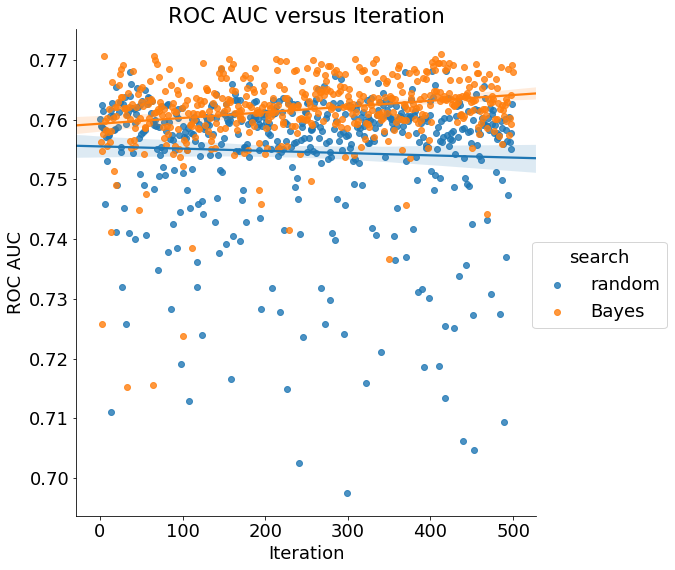

In [54]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, size = 8);
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("ROC AUC versus Iteration");

如果需要，可以把结果都保存下来

In [55]:
import json

# Save the trial results
with open('results/trials.json', 'w') as f:
    f.write(json.dumps(bayes_trials.results))

In [56]:
# Save dataframes of parameters
bayes_params.to_csv('results/bayes_params.csv', index = False)
random_params.to_csv('results/random_params.csv', index = False)

## Continue Searching

可以参考 [pass it a trials object that already has information on previous runs](https://github.com/hyperopt/hyperopt/issues/267). 

接着之前玩过的，继续来玩！

In [57]:
# Continue training
ITERATION = MAX_EVALS + 1

# Set more evaluations
MAX_EVALS = 1000

In [58]:
%%capture

# Use the same trials object to keep training
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, verbose = 1, rstate = np.random.RandomState(50))

In [59]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'estimators': 138,
  'iteration': 846,
  'loss': 0.22763293220783154,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.6311794044268164,
   'learning_rate': 0.027802518491219938,
   'metric': 'auc',
   'min_child_samples': 250,
   'num_leaves': 40,
   'reg_alpha': 0.06183118355912668,
   'reg_lambda': 0.24742831407472365,
   'subsample': 0.999742610271968,
   'subsample_for_bin': 280000,
   'verbose': 1},
  'status': 'ok',
  'train_time': 2.2477611396880093},
 {'estimators': 151,
  'iteration': 743,
  'loss': 0.2282586680303902,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.654904101723946,
   'learning_rate': 0.022834417861761228,
   'metric': 'auc',
   'min_child_samples': 255,
   'num_leaves': 41,
   'reg_alpha': 0.11894237903920345,
   'reg_lambda': 0.8792019672260676,
   'subsample': 0.911075761769854,
   'subsample_for_bin': 280000,
   'verbose': 1},
  'status': 'ok',
  'train_time': 2.357131641913

In [60]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort values with best on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

loss                                             params  iteration  \
0  0.227633  {'boosting_type': 'gbdt', 'class_weight': None...        846   
1  0.228259  {'boosting_type': 'gbdt', 'class_weight': None...        743   
2  0.228292  {'boosting_type': 'gbdt', 'class_weight': None...        837   
3  0.228591  {'boosting_type': 'gbdt', 'class_weight': None...        887   
4  0.228959  {'boosting_type': 'gbdt', 'class_weight': None...        696   

   estimators  train_time  
0         138    2.247761  
1         151    2.357132  
2         182    2.772181  
3         160    2.469558  
4         204    2.948316

In [61]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.6311794044268164,
        learning_rate=0.027802518491219938, max_depth=-1, metric='auc',
        min_child_samples=250, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=138, n_jobs=-1, num_leaves=40, objective='binary',
        random_state=50, reg_alpha=0.06183118355912668,
        reg_lambda=0.24742831407472365, silent=True,
        subsample=0.999742610271968, subsample_for_bin=280000,
        subsample_freq=1, verbose=1)

In [62]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.72736 AUC ROC on the test set.
This was achieved after 846 search iterations


略微的提高，其实我们还可以按照贝叶斯优化给出的大致区间，再进一步网络搜索也是一个不错的套路